In [1]:
from gensim.models import Word2Vec

In [7]:
sentences = [["cat", "say", "meow"], ["dog", "say", "woof"], ["man", "say", "dam"]]

In [17]:
model = Word2Vec(min_count=1, size=10)
model.build_vocab(sentences)
model.train(sentences, total_examples=model.corpus_count, epochs=model.epochs) 
model.save("basic-word2vec.model")

5


In [13]:
model.wv.most_similar("dog")

[('woof', 0.3232297897338867),
 ('dam', 0.14384251832962036),
 ('man', 0.11316978931427002),
 ('cat', -0.06251632422208786),
 ('say', -0.1781214326620102),
 ('meow', -0.21009384095668793)]

In [14]:
print(model.wv.get_vector("dog"))

[ 0.04777663  0.01543251 -0.04632503  0.03601828 -0.00572644  0.00553683
 -0.04476452 -0.0274465   0.0047655   0.00508591]


In [22]:
from sklearn.decomposition import IncrementalPCA    # inital reduction
from sklearn.manifold import TSNE                   # final reduction
import numpy as np                                  # array handling

def reduce_dimensions(model):
    num_dimensions = 2  # final num dimensions (2D, 3D, etc)

    vectors = [] # positions in vector space
    labels = [] # keep track of words to label our data again later
    for word in model.wv.vocab:
        vectors.append(model.wv[word])
        labels.append(word)

    # convert both lists into numpy vectors for reduction
    vectors = np.asarray(vectors)
    labels = np.asarray(labels)

    # reduce using t-SNE
    vectors = np.asarray(vectors)
    tsne = TSNE(n_components=num_dimensions, random_state=0)
    vectors = tsne.fit_transform(vectors)

    x_vals = [v[0] for v in vectors]
    y_vals = [v[1] for v in vectors]
    return x_vals, y_vals, labels


x_vals, y_vals, labels = reduce_dimensions(model)

In [26]:
print(labels)
print(x_vals)
print(y_vals)

['cat' 'say' 'meow' 'dog' 'woof' 'man' 'dam']
[-29.594002, -45.996586, 20.368856, 53.92877, -12.437127, 3.9659712, 37.524284]
[60.112713, 11.891685, 70.019325, 31.70431, -26.423267, 21.79772, -16.517805]


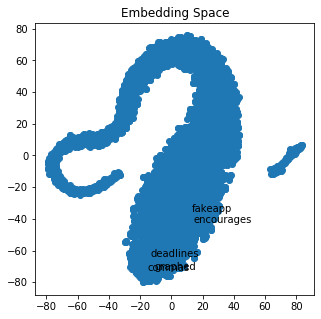

In [78]:
import matplotlib.pyplot as plt
import random

def plot_with_matplotlib(x_vals, y_vals, labels, num_to_label):
    plt.figure(figsize=(5, 5))
    plt.scatter(x_vals, y_vals)
    plt.title("Embedding Space")
    indices = list(range(len(labels)))
    selected_indices = random.sample(indices, num_to_label)
    for i in selected_indices:
        plt.annotate(labels[i], (x_vals[i], y_vals[i]))
        
plot_with_matplotlib(x_vals, y_vals, labels, 5)

In [43]:
def process_file(fileName):
    result = ""
    tempResult = ""
    inCodeBlock = False

    with open(fileName) as file:
        for line in file:
            if line.startswith("```"):
                inCodeBlock = not inCodeBlock
            elif inCodeBlock:
                pass
            else:
                for word in line.split():
                    if "http" not in word and "media/"not  in word:
                        result = result  + " " + word
    return result


print(process_file("data/2018-in-review.md"))

from gensim import utils
print(utils.simple_preprocess(process_file("data/2018-in-review.md")))


 Inspired by [Justin and [Dan I decided to make a 2018 review post. I believe that it would be a good way to reflect upon what I did in 2018 and make plans for 2019. This post will be a very high level overview of the projects and activities that I did in 2018 -- nothing personal. Pictures say a thousand words, so, I will include a lot. # January: **Eagle Ceremony** ![Eagle Ceremony **Started Second Semester of College** Classes: - Mechanics of Programming - Statistics - Discrete Math - Communications - Moral Issues **Brick hack 4** ![Sleep Deprived me at BrickHack # February: **RIT Career Fair** ![Overview Picture of the Career **Build my Blog in Node.js** ![What original website looked # March: **Upgrading Floppy Drive Project** ![Floppy drive project under **Designed Website for Hoffends** ![Hoffends # April: **Imagine RIT** ![RITlug imagine rit ![RITlug imagine rit # May: **End of Second Semester** ![RIT Tiger during the **Started SSA Research Job** ![Erie # June: **Steam Graph Pro

In [49]:
import os
file = open("jrtechs.cor", "w+")
for file_name in os.listdir("data"):
    file.write(process_file("data/" + file_name) + "\n")
file.close()

In [51]:
from gensim.test.utils import datapath
from gensim import utils

class MyCorpus(object):
    """An interator that yields sentences (lists of str)."""

    def __iter__(self):
        corpus_path = "jrtechs.cor"
        for line in open(corpus_path):
            # assume there's one document per line, tokens separated by whitespace
            yield utils.simple_preprocess(line)

In [52]:
sentences = MyCorpus()

In [53]:
model = Word2Vec(min_count=1, size=10, sentences=sentences)
model.train(sentences, total_examples=model.corpus_count, epochs=model.epochs) 
model.save("jrtechs-word2vec.model")

In [59]:
model.wv.most_similar("story")

[('constrained', 0.9626229405403137),
 ('logics', 0.9502561092376709),
 ('slide', 0.9486078023910522),
 ('clip', 0.9481177926063538),
 ('syntactically', 0.9479268789291382),
 ('solace', 0.9447624683380127),
 ('containing', 0.9312535524368286),
 ('claims', 0.928554892539978),
 ('exponential', 0.9284722805023193),
 ('scarce', 0.9266577363014221)]

In [58]:
x_vals, y_vals, labels = reduce_dimensions(model)


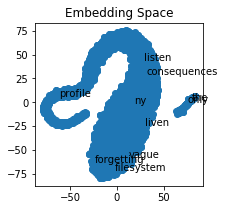

In [63]:
plot_with_matplotlib(x_vals, y_vals, labels, 10)